---
# 3. Bayesian Network creation and analysis
---

# Index  <a name = "index"></a>
1. [Introduction](#intro)
2. [Bayesian Network Structure](#bn_s)
3. [Bayesian Network - Fase 1 (MLE)](#bn_f1_mle)
4. [Bayesian Network - Fase 2 (EM)](#bn_f2_em)
5. [Bayesian Network - Fase 2 (EM) - With Initial CPDs](#bn_f2_em_2)
6. [Saving the Models](#sm)

# Introduction <a name = "intro"></a>
[[go back to Index]](#index)

After a detailed analysis of the CSVs provided for this project and a thorough reading of the project statement, we defined the following structure as a draft of the Bayesian network:

    Bearing Wear ------> Vibration -----------------                
                                                    \               
    Fan Fault --------------                         \              
                            \                         \             
                            Spindle Temperature -------  Overheat   
                            /                         /             
    Cooling Efficiency -----                         /              
                                                    /               
    Clogged Filter ------> Coolant Flow ------------                
                                                                    
    |----------------|   |------------------------|    |----------| 
      Latent Causes       Sensor Values (observed)        Target    

In this project it is natural to divide the Bayesian network into two conceptual parts:

1. A sub-network that only contains **observable variables**, trained with **Maximum Likelihood Estimation (MLE)**;
2. The full network, where we **add the latent (unobserved) causes** and then **train the remaining parameters with the Expectation–Maximisation (EM)** algorithm.

The main reason for this separation is that MLE works best when all variables in the model are directly observed in the data. In the lower part of the network we have quantities such as sensor-based symptoms and the overheat label. For this sub-network, the conditional probability tables can be estimated simply by counting how often each configuration of parent and child values occurs in the data. This gives closed-form MLE estimates that are easy to compute, statistically efficient, and relatively robust. It also allows us to anchor the model on patterns that we genuinely see in the data, rather than relying on guesses.

The latent cause nodes are different. They are never observed directly, so there are no straightforward frequency counts we can use for MLE. If we tried to learn the whole network in one step, every parameter involving a latent node would have to be inferred indirectly, which makes optimisation harder, slower, and more sensitive to initialisation. Introducing EM only at this stage is a principled way to handle the missing information: in the E-step, the algorithm uses the current parameters to infer a probability distribution over the latent causes; in the M-step, it updates the parameters as if those inferred values were soft observations.

By first training the observable part with MLE and only then extending to the latent structure with EM, we obtain several benefits:
- The parameters for the observed relationships are grounded in real data before we start inferring hidden structure;
- EM has a better starting point, which improves convergence and reduces the risk of poor local optima;
- The overall learning problem is decomposed into a simple, fully observed phase and a more complex, partially observed phase, making the workflow clearer and easier to justify in the report.

In short, splitting the Bayesian network in this way respects the distinction between what is directly measured and what is inferred, uses the most appropriate estimation method for each case, and leads to a more stable and interpretable model.

In [1]:
import pandas as pd
import numpy as np

from pgmpy.models import DiscreteBayesianNetwork
from sklearn.model_selection import train_test_split
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

import pickle

In [2]:
from src.bn_creation import *

In [3]:
data = pd.read_csv("data/data_with_labels_and_discretized.csv")

In [4]:
data.head()

,spindle_temp,vibration_rms,coolant_flow,spindle_overheat
0,moderate,low,high,0
1,low,low,high,0
2,low,low,high,0
3,low,low,high,0
4,low,low,high,0


# Bayesian Network Structure <a name = "bn_s"></a>
[[go back to Index]](#index)

After discretizing the values and correcting the labels problem we define the Bayesian Network as:

    Bearing Wear ------> Vibration -----------------                
                                                    \               
    Fan Fault --------------                         \              
                            \                         \             
                            Spindle Temperature -------  Overheat   
                            /                         /             
    Cooling Efficiency -----                         /              
                                                    /               
    Clogged Filter ------> Coolant Flow ------------                
                                                                    
    |----------------|   |------------------------|    |----------| 
      Latent Causes       Sensor Values (observed)        Target    

Where latent causes are binary (0/1):
- Bearing Wear -> There either is a problem with Bearing Wear (1) or not (0)
- Fan Fault -> There either is a Fan Fault (1) or not (0)
- Cooling Efficiency -> There either is a problem with the Cooling Efficiency (1) or not (0)
- Clogged Filter -> There either is a Clogged Filter (1) or not (0)

The Sensor values can either be considered "high", "moderate" or "low"

The overheat variable is binary, there either is a overheat (1) or not (0).

Let's just put the data in a more clear formate and in one that both MLE and EM can use.

In [5]:
bn_data = data[["spindle_temp", "vibration_rms", "coolant_flow", "spindle_overheat"]].rename(
    columns={
        "spindle_temp":   "SpindleTemp",
        "vibration_rms":  "Vibration",
        "coolant_flow":   "CoolantFlow",
        "spindle_overheat": "Overheat"
    }
).copy()

In [6]:
bn_data.head()

,SpindleTemp,Vibration,CoolantFlow,Overheat
0,moderate,low,high,0
1,low,low,high,0
2,low,low,high,0
3,low,low,high,0
4,low,low,high,0


In [7]:
bn_data.dtypes

SpindleTemp    object
Vibration      object
CoolantFlow    object
Overheat        int64
dtype: object

In [8]:
pd.crosstab(bn_data["SpindleTemp"], bn_data["Overheat"])

Overheat,0,1
SpindleTemp,,
high,610,2844
low,36279,0
moderate,62674,1273


In [9]:
pd.crosstab(bn_data["Vibration"], bn_data["Overheat"])

Overheat,0,1
Vibration,,
high,1787,2342
low,34497,4
moderate,63279,1771


In [10]:
pd.crosstab(bn_data["CoolantFlow"], bn_data["Overheat"])

Overheat,0,1
CoolantFlow,,
high,10314,0
low,34378,1959
moderate,54871,2158


In [11]:
bn_data.to_csv("data/bn_data.csv", index=False)

In [12]:
bn_data = pd.read_csv("data/bn_data.csv")

In order to assess the quality of the model, we have divided the data into training and test sets.

In [13]:
target = "Overheat"
disc_cols = ["SpindleTemp", "Vibration", "CoolantFlow"]

bn = bn_data.copy()
bn["combo"]  = bn[disc_cols].astype(str).agg("|".join, axis=1)
bn["strata"] = bn["combo"] + "|y=" + bn[target].astype(str)

test_size = 0.2
seed = 42

# Identify strata that can be split while maintaining at least one sample in the test set
vc = bn["strata"].value_counts()

# for test_size=0.2, we need at least 5 samples to ensure 1 in the test set
min_required = int(np.ceil(1 / test_size))

eligible_strata = vc[vc >= min_required].index
eligible_mask = bn["strata"].isin(eligible_strata)

eligible_idx = bn.index[eligible_mask]
rare_idx     = bn.index[~eligible_mask]   # these go to training set

# Asjust test_size to keep ~20% overall
N = len(bn)
N_test_target = int(round(test_size * N))

if len(eligible_idx) == 0:
    # Everything is rare, we cannot stratify
    train_idx = bn.index
    test_idx = bn.index[:0]  # empty
else:
    # how many tests do we need to take from eligible?
    N_test_from_eligible = max(0, N_test_target - 0)  # rare do not go to test
    N_test_from_eligible = min(N_test_from_eligible, len(eligible_idx) - 1)  # ensure non-empty train

    test_size_eligible = N_test_from_eligible / len(eligible_idx)

    # if fore some reason we get 0 (dataset too small), force at least 1 test
    if test_size_eligible == 0 and len(eligible_idx) >= 2:
        test_size_eligible = 1 / len(eligible_idx)

    tr_el, te_el = train_test_split(
        eligible_idx,
        test_size=test_size_eligible,
        random_state=seed,
        stratify=bn.loc[eligible_idx, "strata"]
    )

    train_idx = np.concatenate([rare_idx.to_numpy(), tr_el])
    test_idx  = te_el

train = bn.loc[train_idx].drop(columns=["combo","strata"])
test  = bn.loc[test_idx].drop(columns=["combo","strata"])

print("Total:", len(bn))
print("Eligible:", len(eligible_idx), "| Rare->train:", len(rare_idx))
print("Train:", len(train), "| Test:", len(test), "| real test_size:", len(test)/len(bn))

Total: 103680
Eligible: 103674 | Rare->train: 6
Train: 82944 | Test: 20736 | real test_size: 0.2


---

# Bayesian Network - Fase 1 (MLE) <a name = "bn_f1_mle"></a>
[[go back to Index]](#index)

**CREATING AND FITTING THE MODEL:**

In [14]:
FEATURES = ["SpindleTemp", "Vibration", "CoolantFlow"]
TARGET = "Overheat"

In [15]:
ORDER3 = ["low", "moderate", "high"]

def enforce_order3(df):
    df = df.copy()
    for col in FEATURES:
        if df[col].dtype == object or "category" in str(df[col].dtype):
            df[col] = pd.Categorical(df[col], categories=ORDER3, ordered=True)
    return df

train_df2 = enforce_order3(train)

print(train_df2[FEATURES + [TARGET]].dtypes)
print(train_df2[FEATURES + [TARGET]].isna().sum())

SpindleTemp    category
Vibration      category
CoolantFlow    category
Overheat          int64
dtype: object
SpindleTemp    0
Vibration      0
CoolantFlow    0
Overheat       0
dtype: int64


In [16]:
# Build MLE model
model_mle = build_mle_model(FEATURES, TARGET)

In [17]:
# Fit the MLE model
model_mle = fit_mle(model_mle, train_df2, FEATURES, TARGET)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'SpindleTemp': 'O', 'Vibration': 'O', 'CoolantFlow': 'O', 'Overheat': 'N'}


**GETTING THE CPDs:**

In [18]:
show_model_cpds(model_mle)

+-----------------------+-----------+
| SpindleTemp(high)     | 0.0333357 |
+-----------------------+-----------+
| SpindleTemp(low)      | 0.349899  |
+-----------------------+-----------+
| SpindleTemp(moderate) | 0.616766  |
+-----------------------+-----------+


+-------------+-------------------+-------------------+---------------------+-------------------+-------------------+---------------------+-----------------------+-----------------------+-----------------------+----------------------+-------------------+---------------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
| CoolantFlow | CoolantFlow(high) | CoolantFlow(high) | CoolantFlow(high)   | CoolantFlow(high) | CoolantFl

**ANALYSING THE RESULTS ON THE TEST SET:**

In [19]:
y_true = test[TARGET].astype(int).values
y_pred, y_prob = predict_overheat_df(test, model_mle, FEATURES, TARGET, threshold=0.50, positive_state=1)

In [20]:
metrics = evaluate_predictions(y_true, y_pred, y_prob=y_prob, verbose=True)

Confusion matrix [[TN, FP],[FN, TP]]:
[[19757   156]
 [  144   679]]

Classification report:
              precision    recall  f1-score   support

           0      0.993     0.992     0.992     19913
           1      0.813     0.825     0.819       823

    accuracy                          0.986     20736
   macro avg      0.903     0.909     0.906     20736
weighted avg      0.986     0.986     0.986     20736

Metrics summary: {'Accuracy': 0.9855324074074074, 'Precision': 0.8131736526946107, 'Recall': 0.8250303766707169, 'F1': 0.8190591073582629, 'AUC': 0.9963384464827834}


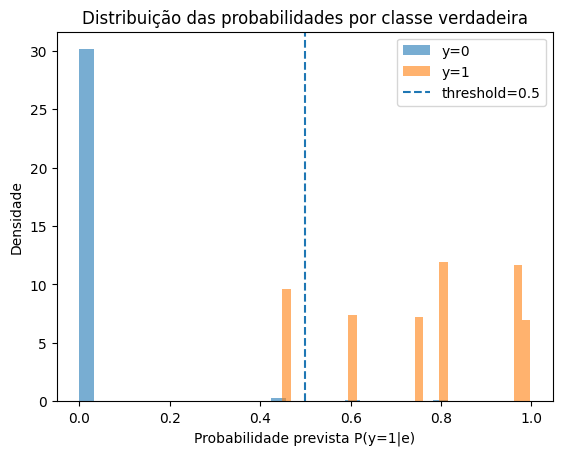

In [21]:
def plot_prob_distributions(y_true, y_prob, bins=30, thr=0.5):
    plt.figure()
    plt.hist(y_prob[y_true == 0], bins=bins, alpha=0.6, label="y=0", density=True)
    plt.hist(y_prob[y_true == 1], bins=bins, alpha=0.6, label="y=1", density=True)
    plt.axvline(thr, linestyle="--", label=f"threshold={thr}")
    plt.xlabel("Probabilidade prevista P(y=1|e)")
    plt.ylabel("Densidade")
    plt.title("Distribuição das probabilidades por classe verdadeira")
    plt.legend()
    plt.show()


plot_prob_distributions(y_true, y_prob)

In which cases the the model get wrong answers?

In [22]:
mask_fp = (y_true == 0) & (y_pred == 1)  # predicted 1, but were 0
fp_cases = test.loc[mask_fp].copy()

# optional: add the predicted probability for inspection
fp_cases["p_overheat_1"] = y_prob[mask_fp]

print("Number of false positives:", mask_fp.sum())
fp_cases.sort_values("p_overheat_1", ascending=False).head(20)

Number of false positives: 156


,SpindleTemp,Vibration,CoolantFlow,Overheat,p_overheat_1
80771,high,moderate,low,0,0.979079
61447,high,moderate,low,0,0.979079
94548,high,moderate,low,0,0.979079
42102,high,moderate,moderate,0,0.809740
11907,high,moderate,moderate,0,0.809740
2405,high,moderate,moderate,0,0.809740
56519,high,moderate,moderate,0,0.809740
72128,high,moderate,moderate,0,0.809740
86817,high,moderate,moderate,0,0.809740
972,high,moderate,moderate,0,0.809740


In [23]:
mask_fp = (y_true == 1) & (y_pred == 0)  # predicted 0, but were 1
fp_cases = test.loc[mask_fp].copy()

# optional: add the predicted probability for inspection
fp_cases["p_overheat_1"] = y_prob[mask_fp]

print("Number of false negatives:", mask_fp.sum())
fp_cases.sort_values("p_overheat_1", ascending=False).head(20)

Number of false negatives: 144


,SpindleTemp,Vibration,CoolantFlow,Overheat,p_overheat_1
35289,moderate,high,moderate,1,0.448868
47277,moderate,high,moderate,1,0.448868
87400,moderate,high,moderate,1,0.448868
71366,moderate,high,moderate,1,0.448868
65241,moderate,high,moderate,1,0.448868
58938,moderate,high,moderate,1,0.448868
48319,moderate,high,moderate,1,0.448868
97217,moderate,high,moderate,1,0.448868
94056,moderate,high,moderate,1,0.448868
94400,moderate,high,moderate,1,0.448868


**CREATING THE INFERENCE INSTANCE AND TESTING SOME SPECIFIC CASES:**

In [24]:
infer_mle = VariableElimination(model_mle)

In [25]:
evidence_case = {"SpindleTemp": "low", "Vibration": "high", "CoolantFlow": "low"}
p_case = overheat_probability(infer_mle, evidence_case, "Overheat", positive_state=1)
print("\nSpecific Case:", evidence_case)
print(f"P(Overheat=1 | evidence) = {p_case:.4f}")


Specific Case: {'SpindleTemp': 'low', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.5000


In [26]:
evidence_case = {"SpindleTemp": "high", "Vibration": "high", "CoolantFlow": "low"}
p_case = overheat_probability(infer_mle, evidence_case, "Overheat", positive_state=1)
print("\nSpecific Case:", evidence_case)
print(f"P(Overheat=1 | evidence) = {p_case:.4f}")


Specific Case: {'SpindleTemp': 'high', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.9976


In [27]:
evidence_case = {"SpindleTemp": "moderate", "Vibration": "high", "CoolantFlow": "low"}
p_case = overheat_probability(infer_mle, evidence_case, "Overheat", positive_state=1)
print("\nSpecific Case:", evidence_case)
print(f"P(Overheat=1 | evidence) = {p_case:.4f}")


Specific Case: {'SpindleTemp': 'moderate', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.6003


In [28]:
evidence_case = {"SpindleTemp": "low", "Vibration": "moderate", "CoolantFlow": "low"}
p_case = overheat_probability(infer_mle, evidence_case, "Overheat", positive_state=1)
print("\nSpecific Case:", evidence_case)
print(f"P(Overheat=1 | evidence) = {p_case:.4f}")


Specific Case: {'SpindleTemp': 'low', 'Vibration': 'moderate', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.0000


In [29]:
evidence_case = {"SpindleTemp": "high", "Vibration": "moderate", "CoolantFlow": "high"}
p_case = overheat_probability(infer_mle, evidence_case, "Overheat", positive_state=1)
print("\nSpecific Case:", evidence_case)
print(f"P(Overheat=1 | evidence) = {p_case:.4f}")


Specific Case: {'SpindleTemp': 'high', 'Vibration': 'moderate', 'CoolantFlow': 'high'}
P(Overheat=1 | evidence) = 0.0000


In [30]:
evidence_case = {"Vibration": "high", "CoolantFlow": "low"}
p_case = overheat_probability(infer_mle, evidence_case, "Overheat", positive_state=1)
print("\nSpecific Case:", evidence_case)
print(f"P(Overheat=1 | evidence) = {p_case:.4f}")


Specific Case: {'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.5784


---

# Bayesian Network - Fase 2 (EM) <a name = "bn_f2_em"></a>
[[go back to Index]](#index)

Now we use the full sketch:
- Latent binary nodes:
    - BearingWear (0/1)
    - FanFault (0/1)
    - CoolingEfficiency (0/1)
    - CloggedFilter (0/1)

- 3-state sensors:
    - SpindleTemp (High, Moderate, Low)
    - Vibration (High, Moderate, Low)
    - CoolantFlow (High, Moderate, Low)

- Target:
    - Overheat (0/1)

**CREATING AND FITTING THE MODEL:**

In [31]:
LATENTS = ["BearingWear", "FanFault", "CloggedFilter", "CoolingEfficiency"]

In [32]:
# Build the EM model
model_em = build_em_model(LATENTS)

In [33]:
# Fit the EM model
model_em = fit_em(model_em, train_df2, latents=LATENTS, features=FEATURES, target=TARGET, max_iter=100, seed=42, atol=1e-12)

**[fit_em] START**

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'SpindleTemp': 'O', 'Vibration': 'O', 'CoolantFlow': 'O', 'Overheat': 'N'}


  0%|          | 0/100 [00:00<?, ?it/s]

**[fit_em] FINISHED** — CPDs: 8

**GETTING THE CPDs:**

In [34]:
show_model_cpds(model_em)

+-------------+-------------------+-------------------+---------------------+-------------------+-------------------+---------------------+-----------------------+-----------------------+-----------------------+----------------------+-------------------+---------------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
| CoolantFlow | CoolantFlow(high) | CoolantFlow(high) | CoolantFlow(high)   | CoolantFlow(high) | CoolantFlow(high) | CoolantFlow(high)   | CoolantFlow(high)     | CoolantFlow(high)     | CoolantFlow(high)     | CoolantFlow(low)     | CoolantFlow(low)  | CoolantFlow(low)    | CoolantFlow(low) | CoolantFlow(low) | CoolantFlow(low)    | CoolantFlow(low)      | CoolantFlow(lo

**ANALYSING THE RESULTS ON THE TEST SET:**

In [35]:
y_true = test[TARGET].astype(int).values
y_pred, y_prob = predict_overheat_df(test, model_em, FEATURES, TARGET, threshold=0.5, positive_state=1)
metrics_em = evaluate_predictions(y_true, y_pred, y_prob=y_prob, verbose=True)

Confusion matrix [[TN, FP],[FN, TP]]:
[[19757   156]
 [  144   679]]

Classification report:
              precision    recall  f1-score   support

           0      0.993     0.992     0.992     19913
           1      0.813     0.825     0.819       823

    accuracy                          0.986     20736
   macro avg      0.903     0.909     0.906     20736
weighted avg      0.986     0.986     0.986     20736

Metrics summary: {'Accuracy': 0.9855324074074074, 'Precision': 0.8131736526946107, 'Recall': 0.8250303766707169, 'F1': 0.8190591073582629, 'AUC': 0.9963384464827834}


**CREATING THE INFERENCE INSTANCE AND TESTING SOME SPECIFIC CASES:**

In [36]:
evidence_case = {"SpindleTemp": "low", "Vibration": "high", "CoolantFlow": "low"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'low', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.5000

Ranking of latent causes (conditioned on Overheat=1):
  - CoolingEfficiency: P(fault) = 0.5671
  - FanFault: P(fault) = 0.4523
  - CloggedFilter: P(fault) = 0.2736
  - BearingWear: P(fault) = 0.2082


In [37]:
evidence_case = {"SpindleTemp": "high", "Vibration": "high", "CoolantFlow": "low"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'high', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.9976

Ranking of latent causes (conditioned on Overheat=1):
  - CloggedFilter: P(fault) = 0.2736
  - FanFault: P(fault) = 0.2406
  - BearingWear: P(fault) = 0.2082
  - CoolingEfficiency: P(fault) = 0.1713


In [38]:
evidence_case = {"SpindleTemp": "moderate", "Vibration": "high", "CoolantFlow": "low"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'moderate', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.6003

Ranking of latent causes (conditioned on Overheat=1):
  - CoolingEfficiency: P(fault) = 0.5272
  - FanFault: P(fault) = 0.4649
  - CloggedFilter: P(fault) = 0.2736
  - BearingWear: P(fault) = 0.2082


In [39]:
evidence_case = {"SpindleTemp": "low", "Vibration": "moderate", "CoolantFlow": "low"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'low', 'Vibration': 'moderate', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.0000
Without cause ranking (p<0.5).


In [40]:
evidence_case = {"SpindleTemp": "high", "Vibration": "moderate", "CoolantFlow": "high"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'high', 'Vibration': 'moderate', 'CoolantFlow': 'high'}
P(Overheat=1 | evidence) = 0.0000
Without cause ranking (p<0.5).


In the tested examples, the inferred “diagnosis” (latent causes) does not seem to be very meaningful. A likely reason is label switching: because the diagnostic node is latent and was learned with EM, its two states have no fixed interpretation, so the model can arbitrarily swap what we call 0 and 1 without changing the fit. As a result, the apparent diagnosis may look inconsistent unless we validate which state corresponds to which clinical meaning.

In [41]:
fault_state_bw = infer_fault_state_by_sensor(model_em, "BearingWear", "Vibration", "high")  # I want high as faulty

[BearingWear] bad=Vibration==high
  P(bad | BearingWear=0) = 0.0827
  P(bad | BearingWear=1) = 0.0134
  => fault_state = 0 (difference = 0.0693)


In [42]:
fault_state_cf = infer_fault_state_by_sensor(model_em, "CloggedFilter", "CoolantFlow", "low")  # I want low as faulty

[CloggedFilter] bad=CoolantFlow==low
  P(bad | CloggedFilter=0) = 0.5947
  P(bad | CloggedFilter=1) = 0.1677
  => fault_state = 0 (difference = 0.4270)


In [43]:
tbl_temp = anchor_table_two_parents(model_em, "SpindleTemp", "high", "FanFault", "CoolingEfficiency")

# decisão automática: qual estado (0/1) tende a aumentar high temp "em média"?
diff_fan = (tbl_temp[(1,0)] + tbl_temp[(1,1)]) - (tbl_temp[(0,0)] + tbl_temp[(0,1)])
diff_ce  = (tbl_temp[(0,1)] + tbl_temp[(1,1)]) - (tbl_temp[(0,0)] + tbl_temp[(1,0)])

fault_state_fan = 1 if diff_fan > 0 else 0
fault_state_ce  = 1 if diff_ce  > 0 else 0

print("\n=> FanFault faulty-state =", fault_state_fan, "(want 1)")
print("=> CoolingEfficiency faulty-state =", fault_state_ce, "(want 1)")


P(SpindleTemp=high | FanFault, CoolingEfficiency)
          CoolingEfficiency=0      CoolingEfficiency=1
FanFault=0   0.0866    0.0104
FanFault=1   0.0249    0.0113

=> FanFault faulty-state = 0 (want 1)
=> CoolingEfficiency faulty-state = 0 (want 1)


In [44]:
with open("models/model_em.pkl", "wb") as f:
    pickle.dump(model_em, f)

Now that we know which cases were switched, we can move on to correcting them:

In [45]:
fault_map = {
    "BearingWear": fault_state_bw,
    "FanFault": fault_state_fan,
    "CoolingEfficiency": fault_state_ce,
    "CloggedFilter": fault_state_cf
}

model_em_corrected = model_em
for lv, fs in fault_map.items():
    if fs == 0:
        print(f"Flipping {lv} (because faulty seems to be 0)")
        model_em_corrected = flip_binary_state_in_model(model_em_corrected, lv)

Flipping BearingWear (because faulty seems to be 0)
Flipping FanFault (because faulty seems to be 0)
Flipping CoolingEfficiency (because faulty seems to be 0)
Flipping CloggedFilter (because faulty seems to be 0)


We will confirm that the changes were successfully made:

In [46]:
infer_fault_state_by_sensor(model_em_corrected, "BearingWear", "Vibration", "high")
infer_fault_state_by_sensor(model_em_corrected, "CloggedFilter", "CoolantFlow", "low")
anchor_table_two_parents(model_em_corrected, "SpindleTemp", "high", "FanFault", "CoolingEfficiency")

[BearingWear] bad=Vibration==high
  P(bad | BearingWear=0) = 0.0134
  P(bad | BearingWear=1) = 0.0827
  => fault_state = 1 (difference = 0.0693)
[CloggedFilter] bad=CoolantFlow==low
  P(bad | CloggedFilter=0) = 0.1677
  P(bad | CloggedFilter=1) = 0.5947
  => fault_state = 1 (difference = 0.4270)

P(SpindleTemp=high | FanFault, CoolingEfficiency)
          CoolingEfficiency=0      CoolingEfficiency=1
FanFault=0   0.0113    0.0249
FanFault=1   0.0104    0.0866


{(0, 0): 0.01127427886089348,
 (0, 1): 0.02493320011306959,
 (1, 0): 0.01038383001877186,
 (1, 1): 0.08664221214445468}

Taking a look on some specific cases:

In [47]:
evidence_case = {"SpindleTemp": "low", "Vibration": "high", "CoolantFlow": "low"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em_corrected, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'low', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.5000

Ranking of latent causes (conditioned on Overheat=1):
  - BearingWear: P(fault) = 0.7918
  - CloggedFilter: P(fault) = 0.7264
  - FanFault: P(fault) = 0.5477
  - CoolingEfficiency: P(fault) = 0.4329


In [48]:
evidence_case = {"SpindleTemp": "high", "Vibration": "high", "CoolantFlow": "low"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em_corrected, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'high', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.9976

Ranking of latent causes (conditioned on Overheat=1):
  - CoolingEfficiency: P(fault) = 0.8287
  - BearingWear: P(fault) = 0.7918
  - FanFault: P(fault) = 0.7594
  - CloggedFilter: P(fault) = 0.7264


In [49]:
evidence_case = {"SpindleTemp": "moderate", "Vibration": "high", "CoolantFlow": "low"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em_corrected, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'moderate', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.6003

Ranking of latent causes (conditioned on Overheat=1):
  - BearingWear: P(fault) = 0.7918
  - CloggedFilter: P(fault) = 0.7264
  - FanFault: P(fault) = 0.5351
  - CoolingEfficiency: P(fault) = 0.4728


Now the diagnoses seem to make more sense.

# Bayesian Network - Fase 2 (EM) - With Initial CPDs <a name = "bn_f2_em_2"></a>
[[go back to Index]](#index)

As we have seen, when we use EM with latent causes, the model can fit the observed sensor/target data in multiple ways that are statistically similar but conceptually different. If we want the latent variables to represent meaningful root causes (e.g., “bearing wear” really means “high vibration is more likely”), we need to give EM a clear starting interpretation.

For 3-state sensors (low/moderate/high), “moderate” often dominates the data, so purely data-driven EM can explain most cases without ever making the latent causes strongly distinct. By defining the faulty columns of P(Sensor∣Cause) by hand, we encode a simple engineering statement:
- When the cause is not faulty (0), the sensor is usually low/moderate and rarely extreme;
- When the cause is faulty (1), the sensor shifts towards the “bad” extreme (high for vibration/temperature, low for coolant flow).

This is not “cheating”: it is injecting domain knowledge to make the latent states identifiable and interpretable. We then validate it by checking:
- (i) whether EM keeps the intended direction.
- (ii) whether prediction of Overheat improves or remains stable.

In [50]:
LATENT_STATES = [0, 1]

Using **Overheat=0** as “healthy-ish” is a practical proxy because:
- Overheat=0 is the overwhelming majority of cases (so it reflects normal operation),
- It gives a baseline sensor profile under non-event conditions,
- It avoids inventing the “healthy” column from thin air.

It’s not perfect, but it’s a sensible starting point for initialisation.

In [51]:
"""
    Returns P(sensor=low/moderate/high | Overheat=0) as a dict in ORDER3 order.
"""
def healthy_profile(df, sensor, target=TARGET, healthy_target_state=0):
    vc = (df[df[target] == healthy_target_state][sensor]
          .value_counts(normalize=True)
          .reindex(ORDER3)
          .fillna(0.0))
    return {s: float(vc[s]) for s in ORDER3}

In [52]:
healthy_vib  = healthy_profile(train_df2, "Vibration")
healthy_temp = healthy_profile(train_df2, "SpindleTemp")
healthy_flow = healthy_profile(train_df2, "CoolantFlow")

print("Healthy Vibration  (Overheat=0):", healthy_vib)
print("Healthy SpindleTemp(Overheat=0):", healthy_temp)
print("Healthy CoolantFlow(Overheat=0):", healthy_flow)

Healthy Vibration  (Overheat=0): {'low': 0.3464783427495292, 'moderate': 0.6355681104833647, 'high': 0.017953546767106088}
Healthy SpindleTemp(Overheat=0): {'low': 0.36436911487758944, 'moderate': 0.6294915254237288, 'high': 0.006139359698681733}
Healthy CoolantFlow(Overheat=0): {'low': 0.34529817953546765, 'moderate': 0.5511111111111111, 'high': 0.10359070935342121}


These dicts will become the Latent=0 columns in the CPDs.

For the faulty cases, we know that:
- BearingWear=1 should make Vibration high common, and low rare.
- FanFault=1 and/or CoolingEfficiency=1 should make Temperature high more common.
- CloggedFilter=1 should make CoolantFlow low common.

In [53]:
# Faulty profiles (manual, logical templates)
faulty_vib  = {"low": 0.05, "moderate": 0.35, "high": 0.60}   # BW=1 -> high vibration
faulty_flow = {"low": 0.65, "moderate": 0.33, "high": 0.02}   # CF=1 -> low flow

# For temperature with 2 parents:
# (FanFault, CoolingEfficiency) = (0,0), (0,1), (1,0), (1,1)
temp_00 = healthy_temp                                     # none faulty
temp_01 = {"low": 0.12, "moderate": 0.68, "high": 0.20}     # only CoolingEfficiency faulty
temp_10 = {"low": 0.10, "moderate": 0.65, "high": 0.25}     # only FanFault faulty
temp_11 = {"low": 0.05, "moderate": 0.35, "high": 0.60}     # both faulty

In [54]:
print("Faulty Vibration  :", faulty_vib)
print("Faulty CoolantFlow:", faulty_flow)
print("Temp (0,0):", temp_00)
print("Temp (0,1):", temp_01)
print("Temp (1,0):", temp_10)
print("Temp (1,1):", temp_11)

Faulty Vibration  : {'low': 0.05, 'moderate': 0.35, 'high': 0.6}
Faulty CoolantFlow: {'low': 0.65, 'moderate': 0.33, 'high': 0.02}
Temp (0,0): {'low': 0.36436911487758944, 'moderate': 0.6294915254237288, 'high': 0.006139359698681733}
Temp (0,1): {'low': 0.12, 'moderate': 0.68, 'high': 0.2}
Temp (1,0): {'low': 0.1, 'moderate': 0.65, 'high': 0.25}
Temp (1,1): {'low': 0.05, 'moderate': 0.35, 'high': 0.6}


In [55]:
def cpd_1parent(sensor, parent, healthy, faulty):
    return TabularCPD(
        variable=sensor, variable_card=3,
        values=[
            [healthy["low"],      faulty["low"]],
            [healthy["moderate"], faulty["moderate"]],
            [healthy["high"],     faulty["high"]],
        ],
        evidence=[parent], evidence_card=[2],
        state_names={sensor: ORDER3, parent: LATENT_STATES}
    )

cpd_vibration_init = cpd_1parent("Vibration", "BearingWear", healthy_vib,  faulty_vib)
cpd_flow_init      = cpd_1parent("CoolantFlow", "CloggedFilter", healthy_flow, faulty_flow)

# 2-parent CPD for temperature: columns (0,0), (0,1), (1,0), (1,1)
cpd_temp_init = TabularCPD(
    variable="SpindleTemp", variable_card=3,
    values=[
        [temp_00["low"],      temp_01["low"],      temp_10["low"],      temp_11["low"]],
        [temp_00["moderate"], temp_01["moderate"], temp_10["moderate"], temp_11["moderate"]],
        [temp_00["high"],     temp_01["high"],     temp_10["high"],     temp_11["high"]],
    ],
    evidence=["FanFault", "CoolingEfficiency"],
    evidence_card=[2, 2],
    state_names={"SpindleTemp": ORDER3, "FanFault": LATENT_STATES, "CoolingEfficiency": LATENT_STATES}
)

# This is the single variable you’ll pass into EM
INIT_CPDS = [cpd_vibration_init, cpd_flow_init, cpd_temp_init]

Sanity check:

In [56]:
for cpd in INIT_CPDS:
    print_full_cpd(cpd)
    print()


+---------------------+----------------------+----------------+
| BearingWear         | BearingWear(0)       | BearingWear(1) |
+---------------------+----------------------+----------------+
| Vibration(low)      | 0.3464783427495292   | 0.05           |
+---------------------+----------------------+----------------+
| Vibration(moderate) | 0.6355681104833647   | 0.35           |
+---------------------+----------------------+----------------+
| Vibration(high)     | 0.017953546767106088 | 0.6            |
+---------------------+----------------------+----------------+

+-----------------------+---------------------+------------------+
| CloggedFilter         | CloggedFilter(0)    | CloggedFilter(1) |
+-----------------------+---------------------+------------------+
| CoolantFlow(low)      | 0.34529817953546765 | 0.65             |
+-----------------------+---------------------+------------------+
| CoolantFlow(moderate) | 0.5511111111111111  | 0.33             |
+--------------------

In [57]:
# Build the EM model
model_em_2 = build_em_model(LATENTS)

In [58]:
# INIT_CPDS is your list: [cpd_vibration_init, cpd_flow_init, cpd_temp_init]

init_cpds_dict = {cpd.variable: cpd for cpd in INIT_CPDS}

# sanity check
print(init_cpds_dict.keys())

dict_keys(['Vibration', 'CoolantFlow', 'SpindleTemp'])


In [59]:
# Fit the EM model
model_em_2 = fit_em_with_init(model_em_2, train_df2, latents=LATENTS, features=FEATURES, target=TARGET, init_cpds=init_cpds_dict, max_iter=100, seed=42, atol=1e-12)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'SpindleTemp': 'O', 'Vibration': 'O', 'CoolantFlow': 'O', 'Overheat': 'N'}


  0%|          | 0/100 [00:00<?, ?it/s]

**GETTING THE CPDs:**

In [60]:
show_model_cpds(model_em)

+-------------+-------------------+-------------------+---------------------+-------------------+-------------------+---------------------+-----------------------+-----------------------+-----------------------+----------------------+-------------------+---------------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
| CoolantFlow | CoolantFlow(high) | CoolantFlow(high) | CoolantFlow(high)   | CoolantFlow(high) | CoolantFlow(high) | CoolantFlow(high)   | CoolantFlow(high)     | CoolantFlow(high)     | CoolantFlow(high)     | CoolantFlow(low)     | CoolantFlow(low)  | CoolantFlow(low)    | CoolantFlow(low) | CoolantFlow(low) | CoolantFlow(low)    | CoolantFlow(low)      | CoolantFlow(lo

**ANALYSING THE RESULTS ON THE TEST SET:**

In [61]:
y_true = test[TARGET].astype(int).values
y_pred, y_prob = predict_overheat_df(test, model_em_2, FEATURES, TARGET, threshold=0.5, positive_state=1)
metrics_em_2 = evaluate_predictions(y_true, y_pred, y_prob=y_prob, verbose=True)

Confusion matrix [[TN, FP],[FN, TP]]:
[[19757   156]
 [  144   679]]

Classification report:
              precision    recall  f1-score   support

           0      0.993     0.992     0.992     19913
           1      0.813     0.825     0.819       823

    accuracy                          0.986     20736
   macro avg      0.903     0.909     0.906     20736
weighted avg      0.986     0.986     0.986     20736

Metrics summary: {'Accuracy': 0.9855324074074074, 'Precision': 0.8131736526946107, 'Recall': 0.8250303766707169, 'F1': 0.8190591073582629, 'AUC': 0.9963384464827834}


**CREATING THE INFERENCE INSTANCE AND TESTING SOME SPECIFIC CASES:**

In [62]:
evidence_case = {"SpindleTemp": "low", "Vibration": "high", "CoolantFlow": "low"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em_2, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'low', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.5000

Ranking of latent causes (conditioned on Overheat=1):
  - BearingWear: P(fault) = 0.9499
  - CloggedFilter: P(fault) = 0.5163
  - CoolingEfficiency: P(fault) = 0.1646
  - FanFault: P(fault) = 0.1427


In [63]:
evidence_case = {"SpindleTemp": "high", "Vibration": "high", "CoolantFlow": "low"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em_2, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'high', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.9976

Ranking of latent causes (conditioned on Overheat=1):
  - BearingWear: P(fault) = 0.9499
  - FanFault: P(fault) = 0.7498
  - CoolingEfficiency: P(fault) = 0.6913
  - CloggedFilter: P(fault) = 0.5163


In [64]:
evidence_case = {"SpindleTemp": "moderate", "Vibration": "high", "CoolantFlow": "low"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em_2, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'moderate', 'Vibration': 'high', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.6003

Ranking of latent causes (conditioned on Overheat=1):
  - BearingWear: P(fault) = 0.9499
  - CloggedFilter: P(fault) = 0.5163
  - CoolingEfficiency: P(fault) = 0.3331
  - FanFault: P(fault) = 0.3216


In [65]:
evidence_case = {"SpindleTemp": "low", "Vibration": "moderate", "CoolantFlow": "low"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em_2, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'low', 'Vibration': 'moderate', 'CoolantFlow': 'low'}
P(Overheat=1 | evidence) = 0.0000
Without cause ranking (p<0.5).


In [66]:
evidence_case = {"SpindleTemp": "high", "Vibration": "moderate", "CoolantFlow": "high"}
print("\n--- Specific Case Specific Case + Diagnosis ---")
print_diagnosis(model_em_2, evidence_case, target=TARGET, latents=LATENTS, overheat_state=1, latent_fault_state=1, top_k=4)


--- Specific Case Specific Case + Diagnosis ---
Evidence (sensors): {'SpindleTemp': 'high', 'Vibration': 'moderate', 'CoolantFlow': 'high'}
P(Overheat=1 | evidence) = 0.0000
Without cause ranking (p<0.5).


We are simply confirming whether label 1 was indeed faulty, despite appearances.

In [67]:
infer_fault_state_by_sensor(model_em_corrected, "BearingWear", "Vibration", "high")
infer_fault_state_by_sensor(model_em_corrected, "CloggedFilter", "CoolantFlow", "low")
anchor_table_two_parents(model_em_corrected, "SpindleTemp", "high", "FanFault", "CoolingEfficiency")

[BearingWear] bad=Vibration==high
  P(bad | BearingWear=0) = 0.0134
  P(bad | BearingWear=1) = 0.0827
  => fault_state = 1 (difference = 0.0693)
[CloggedFilter] bad=CoolantFlow==low
  P(bad | CloggedFilter=0) = 0.1677
  P(bad | CloggedFilter=1) = 0.5947
  => fault_state = 1 (difference = 0.4270)

P(SpindleTemp=high | FanFault, CoolingEfficiency)
          CoolingEfficiency=0      CoolingEfficiency=1
FanFault=0   0.0113    0.0249
FanFault=1   0.0104    0.0866


{(0, 0): 0.01127427886089348,
 (0, 1): 0.02493320011306959,
 (1, 0): 0.01038383001877186,
 (1, 1): 0.08664221214445468}

# Saving the Models <a name = "sm"></a>
[[go back to Index]](#index)

Save both models on Pickle format:

In [68]:
with open("models/model_mle.pkl", "wb") as f:
    pickle.dump(model_mle, f)

In [69]:
with open("models/model_em_corrected.pkl", "wb") as f:
    pickle.dump(model_em_corrected, f)

In [70]:
with open("models/model_em_2.pkl", "wb") as f:
    pickle.dump(model_em_2, f)

To load the model: